# Projet multimodal Airbnb – Superhost

Ce notebook étudie la prédiction du statut `host_is_superhost` à partir :
- de données tabulaires (numériques + catégorielles) ;
- de données textuelles (descriptions, informations hôte, quartier, amenities).

L’objectif est de comparer :
- des modèles unimodaux (tabulaire seul, texte seul) ;
- des modèles multimodaux (early fusion, late fusion).

La question centrale est :
**est‑ce que combiner texte + tabulaire améliore vraiment la performance par rapport à chaque modalité seule ?**


In [1]:
# 1. Imports et configuration

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score,
    f1_score,
)
from sklearn.feature_extraction.text import TfidfVectorizer

import re
import os
import subprocess


pd.set_option("display.max_columns", 100)


# 2. Exploration des données

Dans cette section, on charge le jeu de données, on construit la cible, puis on :
- examine la distribution de `host_is_superhost`,
- regarde les types de variables et leurs statistiques,
- analyse les valeurs manquantes (avec barplots),
- explore la partie texte (exemples, longueur).

Ces observations serviront à justifier les choix de nettoyage et de modélisation.


In [2]:
# 2.1 Chargement et cible

current_dir = os.getcwd()
if len(current_dir) != 0 and re.search(r"^C:\\",current_dir):
    print("directory exist\n")
else:
    raise ValueError("Directory empty\n")

print(current_dir)
print()

found = False
for i in os.listdir(current_dir):
    if i == "listings.csv":
        print("found dataset !\n")
        found = True
        _PATH = os.path.join(current_dir,i)
        data = pd.read_csv(_PATH)
        break
if not found:
    print("CSV NOT FOUND!\n")
    exit(-1)

# Cible binaire
data["host_is_superhost"] = data["host_is_superhost"].map({"f": 0, "t": 1})

print("Shape brute :", data.shape)
print("Aperçu :")
#print(data.head(3))
print("Types :")
print(data.dtypes.value_counts())


directory exist

C:\Users\MLSD24\Desktop\multi\MultiModal_Project

found dataset !

Shape brute : (81853, 79)
Aperçu :
Types :
object     33
float64    26
int64      20
Name: count, dtype: int64


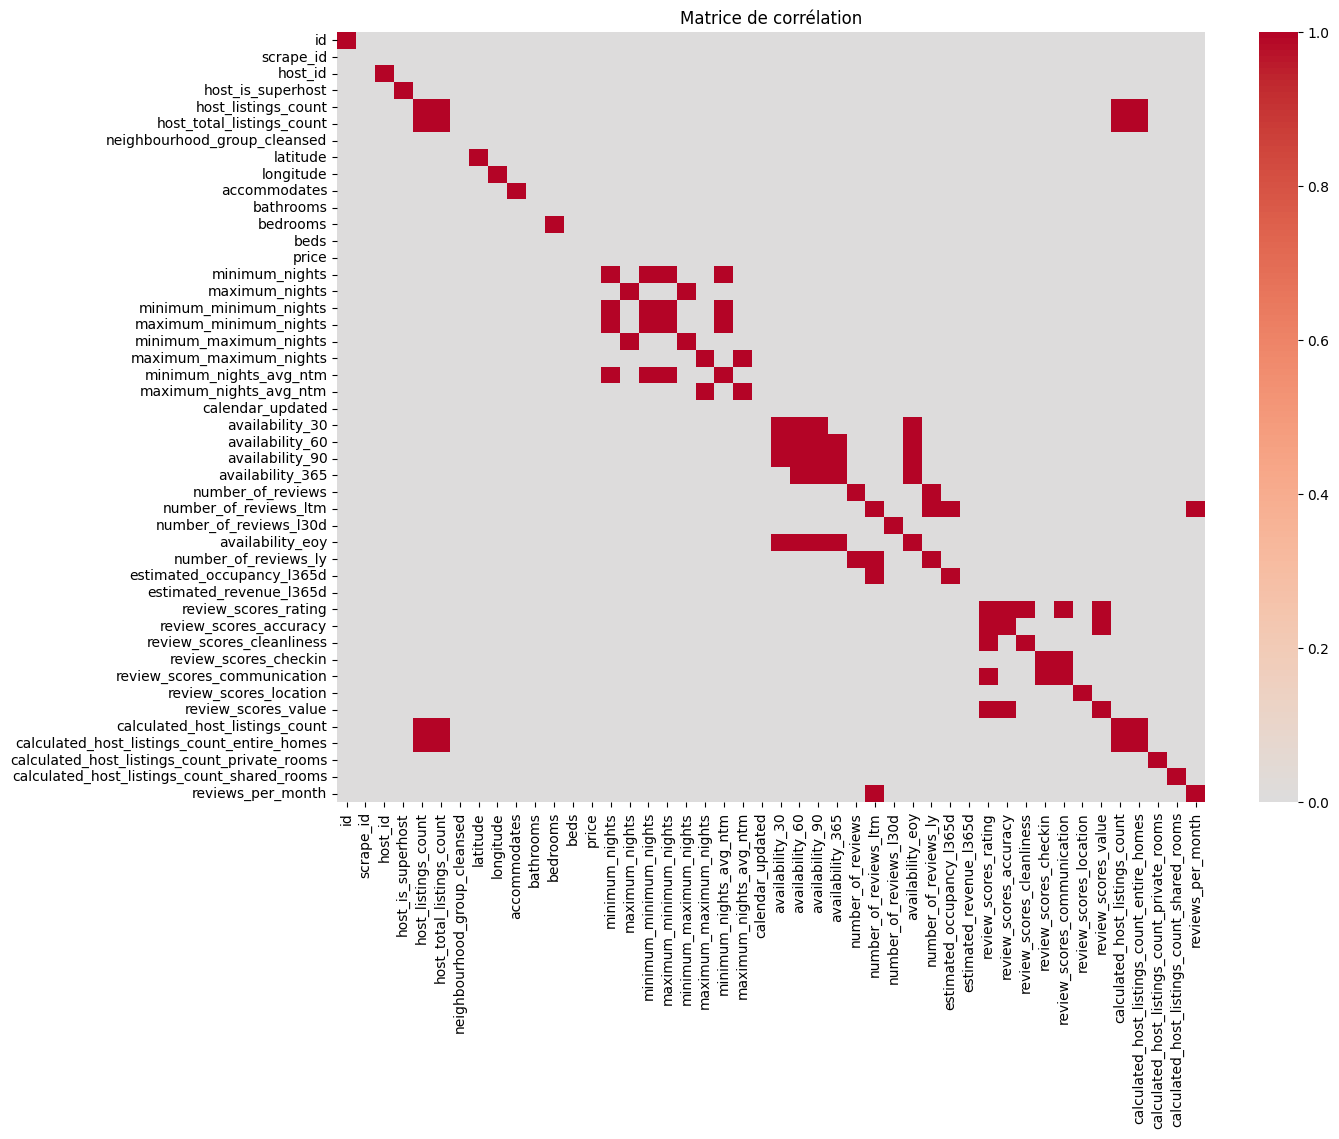

In [3]:
#Matrice de corrélation des variables numériques

import seaborn as sns

# Sélection des colonnes numériques
num = data.select_dtypes(include="number").columns

# Matrice de corrélation complète
corr = data[num].corr()

# Seulement les corrélations fortes (>|0.7|)
strong_cor = corr > 0.7

plt.figure(figsize=(14, 10))
sns.heatmap(strong_cor, cmap="coolwarm", center=0)
plt.title("Matrice de corrélation")
plt.show()

Distribution de la cible :
host_is_superhost
0.0    62568
1.0    16972
NaN     2313
Name: count, dtype: int64
Proportions :
host_is_superhost
0.0    0.764395
1.0    0.207347
NaN    0.028258
Name: count, dtype: float64


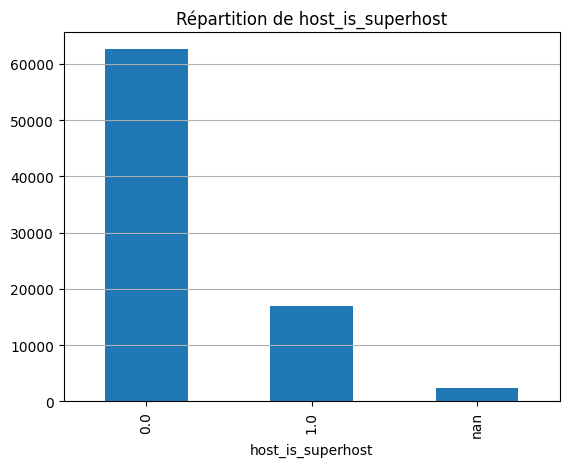

In [4]:
# 2.2 Distribution de la cible

target = "host_is_superhost"

distrib = data[target].value_counts(dropna=False)
print("Distribution de la cible :")
print(distrib)
print("Proportions :")
print(distrib / distrib.sum())

distrib.plot(kind="bar")
plt.title("Répartition de host_is_superhost")
plt.grid(True, axis="y")
plt.show()


### Commentaire – Distribution de la cible

La classe Superhost (1) est minoritaire (≈ 20 %), tandis qu’environ 76 % des observations sont des hôtes non‑Superhosts.  
Ce déséquilibre justifie :
- l’utilisation de métriques adaptées (F1, PR‑AUC) ;
- l’utilisation d’options comme `class_weight="balanced"` dans les classifieurs.


In [5]:
# 2.3 Suppression colonnes techniques

drop_id = ["id", "scrape_id", "host_id"]
drop_urls = [c for c in data.columns if "url" in c.lower()]
drop_scrap = [c for c in data.columns if "scrap" in c.lower() or "source" in c.lower()]

print("Colonnes IDs :", drop_id)
print("Colonnes URLs (extrait) :", drop_urls[:10])
print("Colonnes scraping :", drop_scrap)

data.drop(columns=drop_id + drop_urls + drop_scrap, axis=1, inplace=True)
print("Shape après suppression colonnes techniques :", data.shape)


Colonnes IDs : ['id', 'scrape_id', 'host_id']
Colonnes URLs (extrait) : ['listing_url', 'picture_url', 'host_url', 'host_thumbnail_url', 'host_picture_url']
Colonnes scraping : ['scrape_id', 'last_scraped', 'source', 'calendar_last_scraped']
Shape après suppression colonnes techniques : (81853, 68)


### Commentaire 
Les colonnes d’identifiants, d’URL et de scraping ne contiennent pas d’information directement pertinente pour prédire le statut Superhost, mais décrivent plutôt le contexte technique de collecte des données.
Les supprimer permet de réduire la dimensionnalité, de limiter le risque de fuite d’information liée au scraping et de simplifier les modèles sans perte de signal utile.


#### 2.4 Statistiques + types

In [6]:
# 2.4 Statistiques + types

num_cols_all = data.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols_all = data.select_dtypes(include=["object", "bool"]).columns.tolist()

print("Nb colonnes numériques :", len(num_cols_all))
print("Nb colonnes cat :", len(cat_cols_all))

print("\nStats numériques (top 10) :")
print("resultat trop long, mise en commentaire")
print(data[num_cols_all].describe().T.head(10))

print("\nQuelques colonnes catégorielles :")
for c in cat_cols_all[:5]:
    print("\n===", c, "===")
    print(data[c].value_counts(dropna=False).head(10))


Nb colonnes numériques : 43
Nb colonnes cat : 25

Stats numériques (top 10) :
resultat trop long, mise en commentaire
                                count       mean         std        min  \
host_is_superhost             79540.0   0.213377    0.409694   0.000000   
host_listings_count           81833.0  30.160217  116.081728   0.000000   
host_total_listings_count     81833.0  39.745164  155.466214   0.000000   
neighbourhood_group_cleansed      0.0        NaN         NaN        NaN   
latitude                      81853.0  48.863980    0.018126  48.816090   
longitude                     81853.0   2.343040    0.034218   2.229896   
accommodates                  81853.0   3.221788    1.684614   1.000000   
bathrooms                         0.0        NaN         NaN        NaN   
bedrooms                      66426.0   1.469816    0.867096   0.000000   
beds                              0.0        NaN         NaN        NaN   

                                    25%       50%       

### Conclusion 
Les variables numériques capturent principalement l’activité des hôtes et des logements (volume de reviews, fréquences, disponibilités), tandis que les variables qualitatives décrivent le profil de l’hôte et la nature du logement (type, localisation, stratégie d’accueil).
Certaines de ces variables (niveau d’activité, notation, type de bien, nombre d’annonces de l’hôte) sont particulièrement susceptibles de différencier les Superhosts des autres, ce qui justifie leur utilisation prioritaire dans la modélisation.

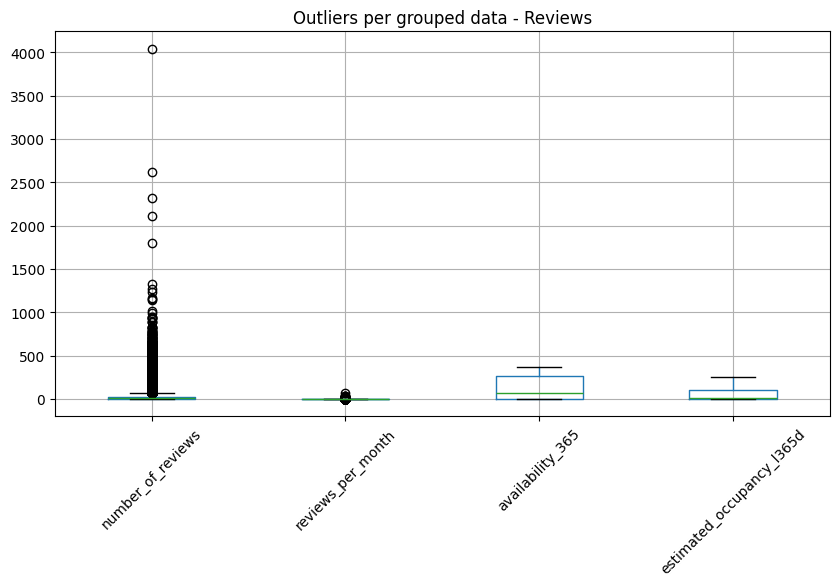

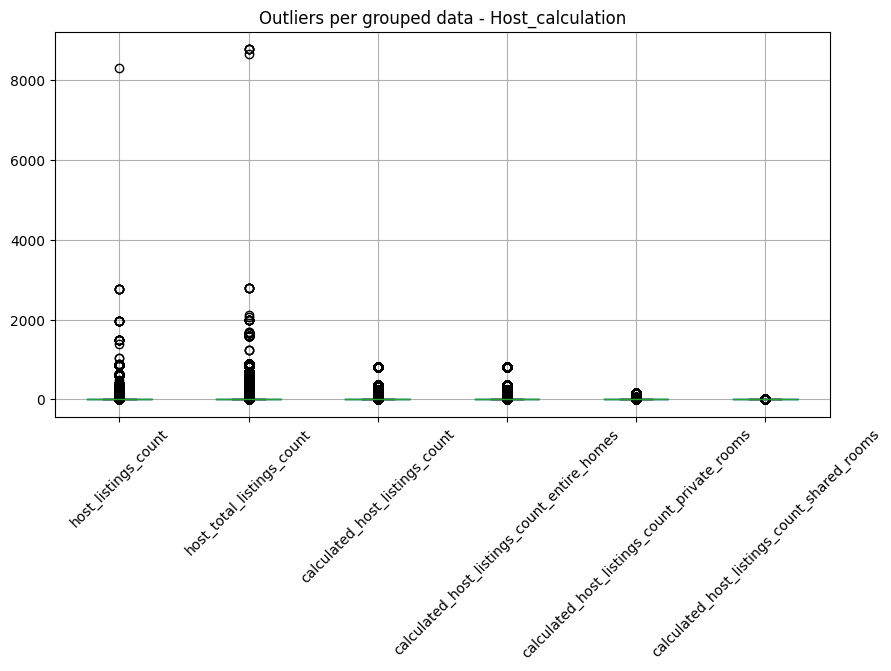

Number of values above the mean in number_of_reviews

20815 observations above the average

Quantiles for number_of_reviews:
0.25      1.00
0.50      7.00
0.75     28.00
0.90     69.00
0.99    293.48
Name: number_of_reviews, dtype: float64


In [7]:
#Boxplots pour visualiser les outliers
#I had an idea, I shall display boxplots to understand outliers in different grouped data

activity_cols = [
    "number_of_reviews",
    "reviews_per_month",
    "availability_365",
    "estimated_occupancy_l365d",
]

host_cols = [
    "host_listings_count",
    "host_total_listings_count",
    "calculated_host_listings_count",
    "calculated_host_listings_count_entire_homes",
    "calculated_host_listings_count_private_rooms",
    "calculated_host_listings_count_shared_rooms",
]

group = {
    "Reviews": activity_cols,
    "Host_calculation": host_cols,
}

for name, cols in group.items():
    data[cols].boxplot(figsize=(10, 5), rot=45)
    plt.title(f"Outliers per grouped data - {name}")
    plt.grid(True)
    plt.show()

print("Number of values above the mean in number_of_reviews\n")
nb_rev_av = data["number_of_reviews"].mean()
nb = (data["number_of_reviews"] > nb_rev_av).sum()
print(f"{nb} observations above the average\n")
print("Quantiles for number_of_reviews:")
print(data["number_of_reviews"].quantile([0.25, 0.5, 0.75, 0.9, 0.99]))


### Commentaire – Outliers et corrélations

Les boxplots montrent des outliers sur les variables d’activité (reviews, nombre de listings, etc.).  
La matrice de corrélation met en évidence des variables très redondantes entre elles, ce qui peut :
- renforcer le pouvoir prédictif,
- mais aussi créer un risque de fuite d'information si certaines colonnes sont trop proches de la cible.


Top 20 colonnes NA :
calendar_updated                1.000000
neighbourhood_group_cleansed    1.000000
bathrooms                       1.000000
estimated_revenue_l365d         1.000000
beds                            1.000000
price                           1.000000
host_neighbourhood              0.657948
host_about                      0.554042
neighbourhood                   0.516206
neighborhood_overview           0.516206
host_response_time              0.393449
host_response_rate              0.393449
host_acceptance_rate            0.319231
review_scores_checkin           0.219638
review_scores_value             0.219638
review_scores_location          0.219625
review_scores_accuracy          0.219552
review_scores_communication     0.219528
review_scores_cleanliness       0.219515
review_scores_rating            0.219418
dtype: float64


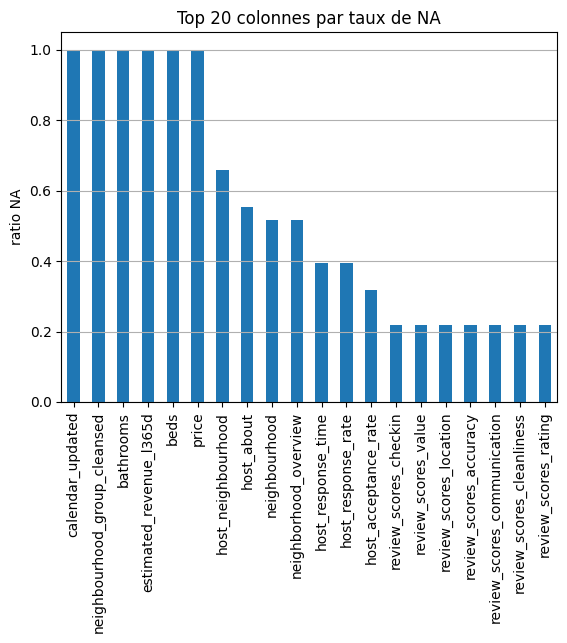


=== host_about ===
host_about
True     45350
False    36503
Name: count, dtype: int64


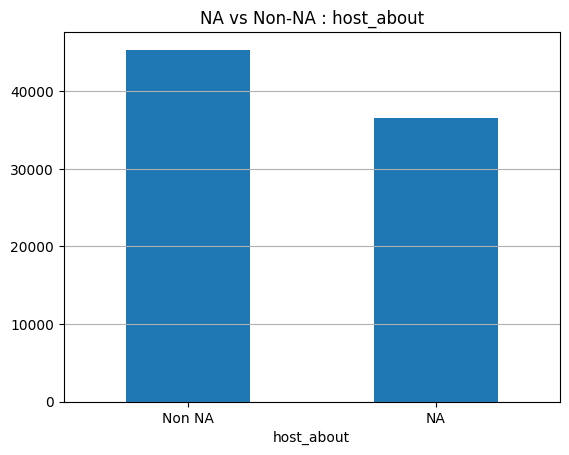


=== description ===
description
False    79140
True      2713
Name: count, dtype: int64


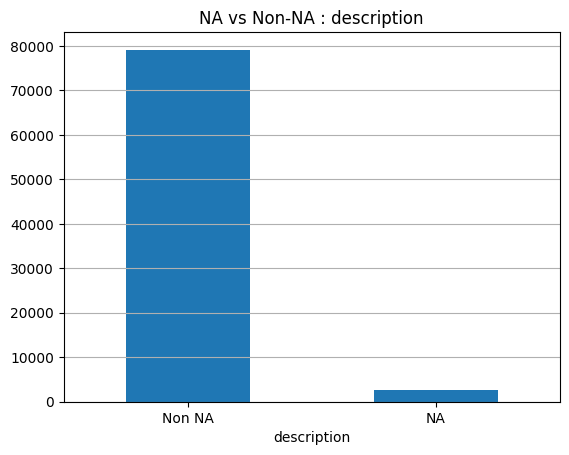


=== neighborhood_overview ===
neighborhood_overview
True     42253
False    39600
Name: count, dtype: int64


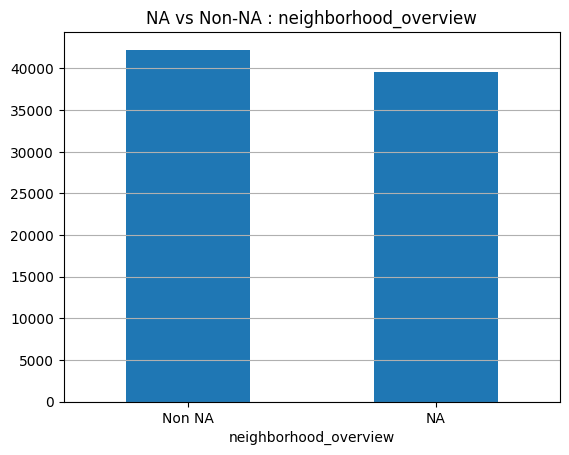


=== reviews_per_month ===
reviews_per_month
False    63893
True     17960
Name: count, dtype: int64


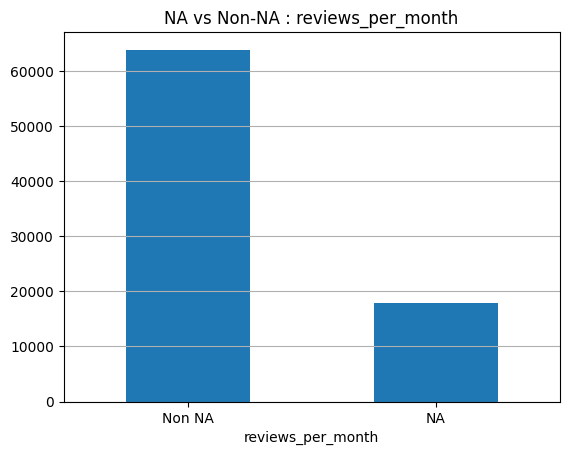

In [8]:
# 2.5 NA (avec barplots)

na_ratio_sorted = data.isna().mean().sort_values(ascending=False)
print("Top 20 colonnes NA :")
print(na_ratio_sorted.head(20))

na_ratio_sorted.head(20).plot(kind="bar")
plt.title("Top 20 colonnes par taux de NA")
plt.ylabel("ratio NA")
plt.grid(True, axis="y")
plt.show()

# affichage sur quelques colonnes clé
cols_check = ["host_about", "description", "neighborhood_overview", "reviews_per_month"]
cols_check = [c for c in cols_check if c in data.columns]

for c in cols_check:
    print("\n===", c, "===")
    counts = data[c].isna().value_counts()
    print(counts)
    counts.plot(kind="bar")
    plt.title(f"NA vs Non-NA : {c}")
    plt.xticks([0,1], ["Non NA","NA"], rotation=0)
    plt.grid(True, axis="y")a
    plt.show()


### Commentaire – Tabulaire et valeurs manquantes

Les variables numériques décrivent l’activité de l’hôte et du logement (reviews, disponibilités, nombre d’annonces, etc.).  
Plusieurs variables (scores de review, host_about, neighborhood_overview, etc.) ont beaucoup de valeurs manquantes, ce qui justifie l’imputation (médiane pour les numériques, modalité la plus fréquente ou "missing" pour les catégorielles/texte).

In [9]:
# 2.6 Suppression des colonnes avec > 80% de NA

na_ratio = data.isna().mean()
cols_high_na = na_ratio[na_ratio > 0.8].index.tolist()

print("Nombre de colonnes avec > 80% de NA :", len(cols_high_na))
print("Colonnes supprimées car > 80% NA :")
print(cols_high_na)

data.drop(columns=cols_high_na, inplace=True)
print("Shape après suppression des colonnes > 80% NA :", data.shape)

# Recalcul des listes de colonnes après nettoyage
num_cols_all = data.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols_all = data.select_dtypes(include=["object", "bool"]).columns.tolist()
print("Nb colonnes numériques après nettoyage :", len(num_cols_all))
print("Nb colonnes cat après nettoyage :", len(cat_cols_all))


Nombre de colonnes avec > 80% de NA : 6
Colonnes supprimées car > 80% NA :
['neighbourhood_group_cleansed', 'bathrooms', 'beds', 'price', 'calendar_updated', 'estimated_revenue_l365d']
Shape après suppression des colonnes > 80% NA : (81853, 62)
Nb colonnes numériques après nettoyage : 37
Nb colonnes cat après nettoyage : 25


### Conclusion

Les colonnes présentant plus de 80 % de valeurs manquantes ont un pouvoir informatif très limité et augmentent surtout la complexité du prétraitement (imputation, encodage) sans véritable bénéfice.
Elles sont donc supprimées, de même que les colonnes entièrement vides, afin de simplifier le jeu de données, réduire le risque de sur‑apprentissage et concentrer la modélisation sur des variables mieux renseignées.


#### 2.7 Texte (exemples + longueur)

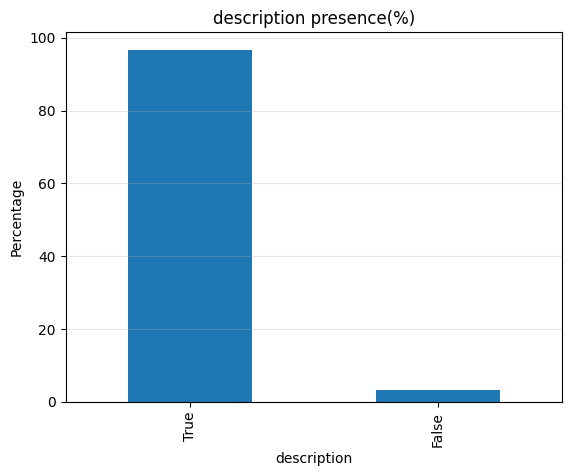

In [10]:
text_present = (data["description"].str.len() > 0)

distrib = text_present.value_counts(normalize=True) * 100

distrib.plot(kind="bar")
plt.title("description presence(%)")
plt.ylabel("Percentage")
plt.grid(axis="y", alpha=0.3)
plt.show()


Colonnes texte : ['name', 'description', 'neighborhood_overview', 'host_about', 'amenities']

=== Exemples description Superhosts ===
1     In the heart of historical Paris le Marais, gr...
5     Experience luxury on the 6th floor with elevat...
12    Completely renovated, calm, clear, confortable...
Name: description, dtype: object

=== Exemples description Non-Superhosts ===
0    This beautiful apartment is very well located ...
2    A stone's throw from Parc Monceau and the Arc ...
3    Cozy apartment close to everything.<br />Perfe...
Name: description, dtype: object

=== Exemples host_about Superhosts ===
1    I travel a lot for work and when I'm away, my ...
5    Passionné d'art et styliste de profession, je ...
8    Like travailling and know difference cultures ...
Name: host_about, dtype: object

=== Exemples host_about Non-Superhosts ===
0    I am living in Paris since 10 years, and I lov...
3    Jeune ingénieur, je propose mon appartement à ...
7    Nous serons à votre écoute

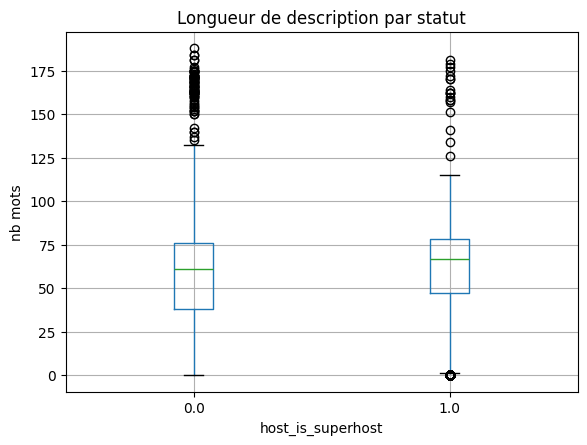

In [11]:
# 2.7 Texte (exemples + longueur)

text_cols = [c for c in ["name","description","neighborhood_overview","host_about","amenities"]
             if c in data.columns]
print("Colonnes texte :", text_cols)

# Exemples texte par classe
for col in ["description","host_about"]:
    if col in data.columns:
        print("\n=== Exemples", col, "Superhosts ===")
        print(data.loc[data[target]==1, col].dropna().head(3))
        print("\n=== Exemples", col, "Non-Superhosts ===")
        print(data.loc[data[target]==0, col].dropna().head(3))

# Longueur description
if "description" in data.columns:
    data["length_description"] = data["description"].fillna("").astype(str).str.split().str.len()
    print("\nStats longueur description :")
    print(data["length_description"].describe())

    data.boxplot(column="length_description", by=target)
    plt.title("Longueur de description par statut")
    plt.suptitle("")
    plt.ylabel("nb mots")
    plt.grid(True)
    plt.show()


### Conclusion

Les descriptions et champs texte contiennent des informations qualitatives sur le style de communication, le niveau de détail et le professionnalisme des hôtes, ce qui justifie la mise en place d’un modèle texte dédié.
La longueur de la description semble porter un léger signal (les Superhosts écrivent en moyenne davantage), mais les distributions se chevauchent fortement ; cette variable, prise isolément, ne permet donc pas de bien séparer les classes et doit être exploitée en combinaison avec d’autres features textuelles et tabulaires.

# 3. Modélisation unimodale

On sépare maintenant :
- un bloc **tabulaire** (numérique + catégoriel),
- un bloc **texte** (TF‑IDF).

On entraîne des modèles sur chaque modalité pour obtenir des baselines :
- tabulaire seul : Logistic Regression et Random Forest,
- texte seul : TF‑IDF + Logistic Regression. 


In [30]:
# 3.1 Préparation tabulaire

target = "host_is_superhost"

# On garde seulement les lignes avec une cible connue
data_use = data[data[target].notna()].copy()
y = data_use[target].astype(int)

print("Shape data_use :", data_use.shape)
print("Distribution cible :")
print(y.value_counts(normalize=True))

# Colonnes texte à exclure du tabulaire
text_cols = [c for c in ["name","description","neighborhood_overview","host_about","amenities"]
             if c in data_use.columns]

# Colonnes de dates / scrap à exclure
date_cols = [c for c in data_use.columns if "review" in c.lower() and "date" in c.lower()] + \
            [c for c in data_use.columns if "scrap" in c.lower()]

print("Colonnes texte retirées :", text_cols)
print("Colonnes date/scrap retirées :", date_cols)

# Bloc tabulaire = tout sauf texte + dates
X_tab = data_use.drop(columns=text_cols + date_cols, errors="ignore")

# Séparation num / cat
num_cols = X_tab.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols = X_tab.select_dtypes(include=["object","bool"]).columns.tolist()

print("Shape X_tab :", X_tab.shape)
print("Nb colonnes numériques :", len(num_cols))
print("Nb colonnes catégorielles :", len(cat_cols))

# Split train/test
X_train_tab, X_test_tab, y_train, y_test = train_test_split(
    X_tab, y, test_size=0.2, random_state=42, stratify=y
)

print("X_train_tab :", X_train_tab.shape)
print("X_test_tab  :", X_test_tab.shape)
print("y_train :", y_train.shape)
print("y_test  :", y_test.shape)
print("Nb de NA restants dans X_tab :", X_tab.isna().sum().sum())


Shape data_use : (79540, 63)
Distribution cible :
host_is_superhost
0    0.786623
1    0.213377
Name: proportion, dtype: float64
Colonnes texte retirées : ['name', 'description', 'neighborhood_overview', 'host_about', 'amenities']
Colonnes date/scrap retirées : []
Shape X_tab : (79540, 58)
Nb colonnes numériques : 38
Nb colonnes catégorielles : 20
X_train_tab : (63632, 58)
X_test_tab  : (15908, 58)
y_train : (63632,)
y_test  : (15908,)
Nb de NA restants dans X_tab : 412336


Shape X_train_num : (63632, 38)
Shape X_train_cat : (63632, 66444)
Shape X_train_final : (63632, 66482)
Shape X_test_final  : (15908, 66482)

=== Logistic Regression (tabulaire) ===
              precision    recall  f1-score   support

           0      1.000     1.000     1.000     12514
           1      1.000     1.000     1.000      3394

    accuracy                          1.000     15908
   macro avg      1.000     1.000     1.000     15908
weighted avg      1.000     1.000     1.000     15908

ROC-AUC : 1.0
PR-AUC  : 1.0
Confusion matrix (Logistic Regression) :
 [[12514     0]
 [    0  3394]]


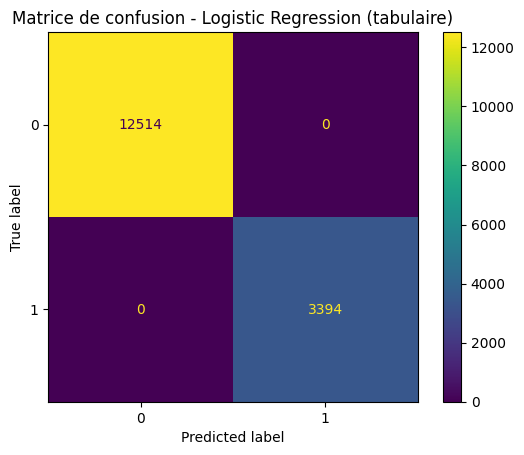


=== Random Forest (tabulaire) ===
              precision    recall  f1-score   support

           0      0.968     0.997     0.982     12514
           1      0.988     0.878     0.930      3394

    accuracy                          0.972     15908
   macro avg      0.978     0.938     0.956     15908
weighted avg      0.972     0.972     0.971     15908

ROC-AUC : 0.998062982659186
PR-AUC  : 0.9928824617480876
Confusion matrix (Random Forest) :
 [[12478    36]
 [  413  2981]]


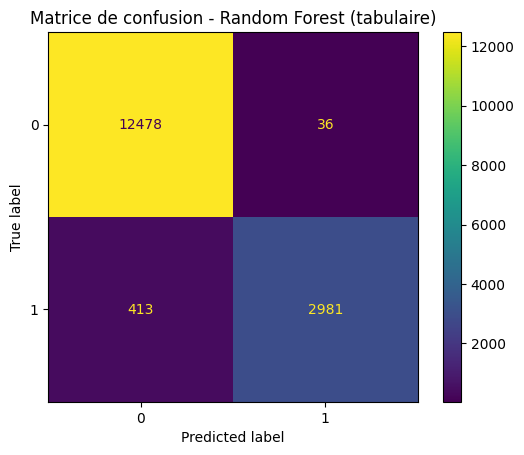

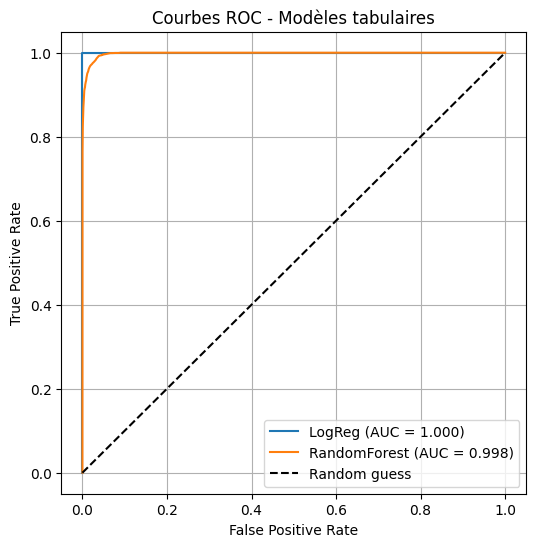

In [13]:
# 3.2 Logistic Regression + RandomForest (tabulaire(cat + num)) avec imputation 

# 1) NUMÉRIQUE : imputer + standardiser
imputer_num = SimpleImputer(strategy="median")
scaler_num = StandardScaler()

X_train_num = imputer_num.fit_transform(X_train_tab[num_cols])
X_test_num  = imputer_num.transform(X_test_tab[num_cols])

X_train_num = scaler_num.fit_transform(X_train_num)
X_test_num  = scaler_num.transform(X_test_num)

print("Shape X_train_num :", X_train_num.shape)

# 2) CATÉGORIEL : imputer + OneHot
imputer_cat = SimpleImputer(strategy="most_frequent")

X_train_cat_raw = imputer_cat.fit_transform(X_train_tab[cat_cols])
X_test_cat_raw  = imputer_cat.transform(X_test_tab[cat_cols])

ohe = OneHotEncoder(handle_unknown="ignore")  # sparse par défaut
X_train_cat = ohe.fit_transform(X_train_cat_raw)
X_test_cat  = ohe.transform(X_test_cat_raw)

print("Shape X_train_cat :", X_train_cat.shape)

# 3) CONCATÉNER num + cat (sparse)
X_train_num_sp = sparse.csr_matrix(X_train_num)
X_test_num_sp  = sparse.csr_matrix(X_test_num)

X_train_final = sparse.hstack([X_train_num_sp, X_train_cat])
X_test_final  = sparse.hstack([X_test_num_sp, X_test_cat])

print("Shape X_train_final :", X_train_final.shape)
print("Shape X_test_final  :", X_test_final.shape)

# 4) LOGISTIC REGRESSION
lr = LogisticRegression(class_weight="balanced", max_iter=1000, n_jobs=-1)
lr.fit(X_train_final, y_train)

proba_lr = lr.predict_proba(X_test_final)[:, 1]
pred_lr = (proba_lr >= 0.5).astype(int)

print("\n=== Logistic Regression (tabulaire) ===")
print(classification_report(y_test, pred_lr, digits=3))
print("ROC-AUC :", roc_auc_score(y_test, proba_lr))
print("PR-AUC  :", average_precision_score(y_test, proba_lr))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Matrice de confusion pour la Logistic Regression tabulaire
cm_lr = confusion_matrix(y_test, pred_lr)
print("Confusion matrix (Logistic Regression) :\n", cm_lr)

disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr,
                                 display_labels=[0, 1])
disp_lr.plot(values_format="d")
plt.title("Matrice de confusion - Logistic Regression (tabulaire)")
plt.show()


# 5) RANDOM FOREST
rf = RandomForestClassifier(
    n_estimators=150,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train_final, y_train)

proba_rf = rf.predict_proba(X_test_final)[:, 1]
pred_rf = (proba_rf >= 0.5).astype(int)

print("\n=== Random Forest (tabulaire) ===")
print(classification_report(y_test, pred_rf, digits=3))
print("ROC-AUC :", roc_auc_score(y_test, proba_rf))
print("PR-AUC  :", average_precision_score(y_test, proba_rf))

# Matrice de confusion pour la Random Forest tabulaire
cm_rf = confusion_matrix(y_test, pred_rf)
print("Confusion matrix (Random Forest) :\n", cm_rf)

disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf,
                                 display_labels=[0, 1])
disp_rf.plot(values_format="d")
plt.title("Matrice de confusion - Random Forest (tabulaire)")
plt.show()


from sklearn.metrics import roc_curve, RocCurveDisplay
# Courbes ROC pour Logistic Regression et Random Forest
fpr_lr, tpr_lr, _ = roc_curve(y_test, proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, proba_rf)

plt.figure(figsize=(6, 6))
plt.plot(fpr_lr, tpr_lr, label="LogReg (AUC = {:.3f})".format(roc_auc_score(y_test, proba_lr)))
plt.plot(fpr_rf, tpr_rf, label="RandomForest (AUC = {:.3f})".format(roc_auc_score(y_test, proba_rf)))
plt.plot([0, 1], [0, 1], "k--", label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbes ROC - Modèles tabulaires")
plt.legend()
plt.grid(True)
plt.show()



### Commentaire – Logistic Regression tabulaire

La régression logistique tabulaire atteint des scores parfaits (F1=1, ROC‑AUC=1, PR‑AUC=1) et une matrice de confusion sans aucune erreur.  
C’est très inhabituel sur des données réelles et cela suggère :
- soit une variable quasiment équivalente à la cible dans les features,
- soit une fuite d’information (information de "Superhost" recopiée dans une autre colonne).

En pratique, il faudrait inspecter les colonnes les plus corrélées à `host_is_superhost` et éventuellement en exclure certaines pour obtenir une estimation plus réaliste des performances.


### Commentaire – Random Forest tabulaire

La Random Forest obtient aussi d’excellentes performances (ROC‑AUC ~0.998, PR‑AUC ~0.993), mais avec quelques erreurs (faux négatifs et faux positifs).  
Ce comportement est plus réaliste : le tabulaire capture déjà quasiment toute l’information utile pour prédire le statut Superhost.


In [38]:
# 3.3 Modèle texte seul (TF-IDF + LR)

# Construction du texte global
data_use["full_text"] = (
    data_use.get("description","").fillna("") + " " +
    data_use.get("host_about","").fillna("") + " " +
    data_use.get("neighborhood_overview","").fillna("")
)

X_text = data_use["full_text"]

X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

tfidf = TfidfVectorizer(max_features=20000, min_df=5, stop_words="english")
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf  = tfidf.transform(X_test_text)

lr_text = LogisticRegression(class_weight="balanced", max_iter=2000, n_jobs=-1)
lr_text.fit(X_train_tfidf, y_train_text)

proba_text = lr_text.predict_proba(X_test_tfidf)[:, 1]
pred_text = (proba_text >= 0.5).astype(int)

print("\n=== Modèle TEXTE seul (TF-IDF + LR, sans pipeline) ===")
print(classification_report(y_test_text, pred_text, digits=3))
print("ROC-AUC :", roc_auc_score(y_test_text, proba_text))
print("PR-AUC  :", average_precision_score(y_test_text, proba_text))



=== Modèle TEXTE seul (TF-IDF + LR, sans pipeline) ===
              precision    recall  f1-score   support

           0      0.885     0.750     0.812     12514
           1      0.410     0.640     0.500      3394

    accuracy                          0.727     15908
   macro avg      0.647     0.695     0.656     15908
weighted avg      0.784     0.727     0.745     15908

ROC-AUC : 0.7754084429563814
PR-AUC  : 0.564511138951904


In [39]:
data_use.ndim

2

### Commentaire – Modèle texte seul (TF-IDF + LR)

Le texte seul atteint une ROC‑AUC d’environ 0.84 et une PR‑AUC autour de 0.63, nettement en dessous du tabulaire.  
Le texte apporte donc un signal utile (style d’écriture, vocabulaire), mais moins fort que les variables d’activité/notes.  
On observe un bon rappel sur la classe 1 mais une précision plus faible (beaucoup de faux positifs).


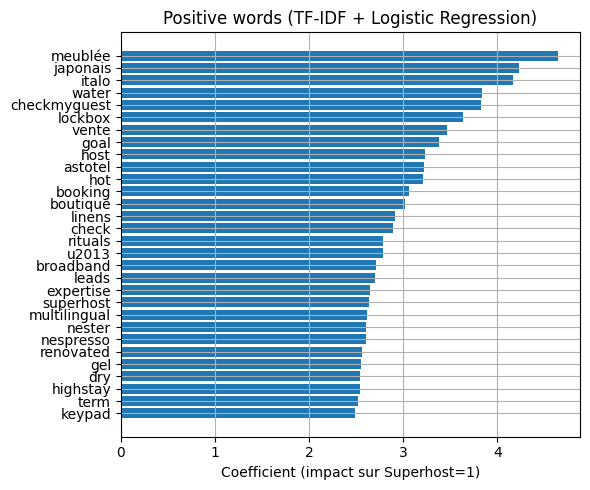

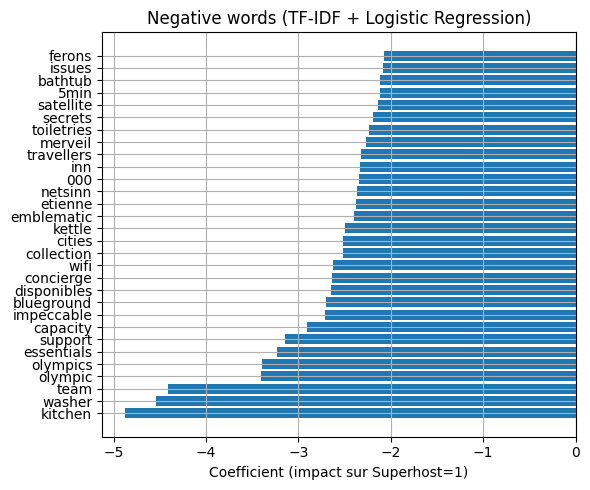

In [15]:
# Interprétabilité - mots positifs / négatifs
# 1) Récupérer les noms de features (mots / n-grams) et les coefficients du modèle
feat_names = tfidf.get_feature_names_out()      # tableau de chaînes
coeffs = lr_text.coef_[0]                      # poids pour la classe 1

# 2) Top 30 mots les plus "positifs" pour la classe 1 (Superhost)
pos_idx = np.argsort(coeffs)[-30:]             # indices des 30 plus grands coeffs
pos_words = feat_names[pos_idx]
pos_weights = coeffs[pos_idx]

# 3) Top 30 mots les plus "négatifs" pour la classe 1 (fortement pro-classe 0)
neg_idx = np.argsort(coeffs)[:30]              # indices des 30 plus petits coeffs
neg_words = feat_names[neg_idx]
neg_weights = coeffs[neg_idx]

# 4) Affichage - mots positifs
plt.figure(figsize=(6, 5))
plt.barh(pos_words, pos_weights)
plt.title("Positive words (TF-IDF + Logistic Regression)")
plt.xlabel("Coefficient (impact sur Superhost=1)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 5) Affichage - mots négatifs
plt.figure(figsize=(6, 5))
plt.barh(neg_words, neg_weights)
plt.title("Negative words (TF-IDF + Logistic Regression)")
plt.xlabel("Coefficient (impact sur Superhost=1)")
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\MLSD24\lion\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(



=== LinearSVC (texte seul) ===
              precision    recall  f1-score   support

           0      0.909     0.786     0.843     12514
           1      0.474     0.709     0.568      3394

    accuracy                          0.770     15908
   macro avg      0.691     0.748     0.706     15908
weighted avg      0.816     0.770     0.784     15908



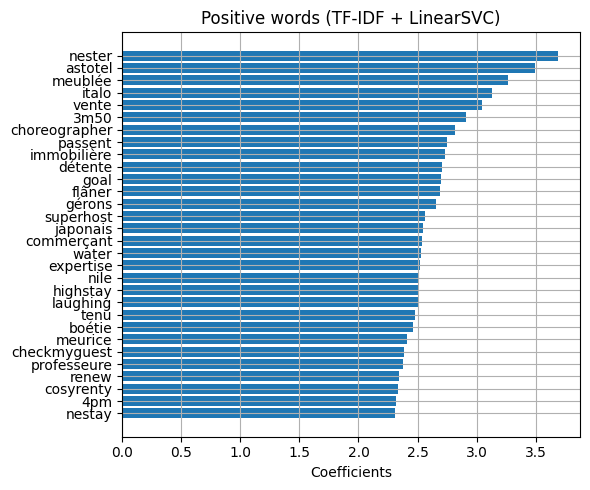

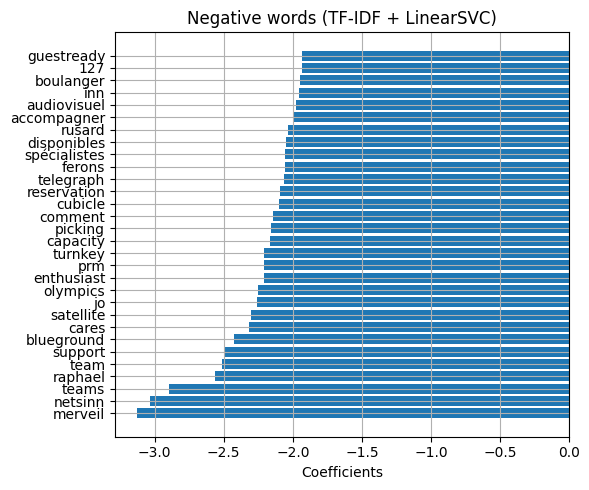

In [16]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

# Split texte
X_train, X_test, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, stratify=y, random_state=42
)

# Pipeline TF-IDF + LinearSVC
pi_svm = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=20000, min_df=5, stop_words="english")),
    ("clf", LinearSVC(class_weight="balanced", max_iter=5000)),
])

# Entraînement
pi_svm.fit(X_train, y_train)

# Prédictions
y_pred = pi_svm.predict(X_test)
print("\n=== LinearSVC (texte seul) ===")
print(classification_report(y_test, y_pred, digits=3))

# --- Interprétation des mots importants ---

tfidf_svm = pi_svm.named_steps["tfidf"]
clf_svm = pi_svm.named_steps["clf"]

# Noms des features et coefficients pour la classe 1
feat_names = tfidf_svm.get_feature_names_out()
coeffs = clf_svm.coef_[0]

# 30 mots les plus "positifs" pour Superhost (classe 1)
pos_idx = np.argsort(coeffs)[-30:]
pos_words = feat_names[pos_idx]
pos_weights = coeffs[pos_idx]

# 30 mots les plus "négatifs" pour Superhost (pro-classe 0)
neg_idx = np.argsort(coeffs)[:30]
neg_words = feat_names[neg_idx]
neg_weights = coeffs[neg_idx]

# Plot des mots positifs
plt.figure(figsize=(6, 5))
plt.barh(pos_words, pos_weights)
plt.title("Positive words (TF-IDF + LinearSVC)")
plt.xlabel("Coefficients")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot des mots négatifs
plt.figure(figsize=(6, 5))
plt.barh(neg_words, neg_weights)
plt.title("Negative words (TF-IDF + LinearSVC)")
plt.xlabel("Coefficients")
plt.grid(True)
plt.tight_layout()
plt.show()


### Commentaire – Mots discriminants (texte)

Les coefficients des modèles linéaires (LR, LinearSVC) mettent en évidence :
- des mots **positifs** fortement associés aux Superhosts (vocabulaire plus professionnel / orienté service) ;
- des mots **négatifs** plutôt liés aux non‑Superhosts.

Cela montre qualitativement ce que le modèle texte apprend, même si, quantitativement, il reste moins performant que le tabulaire.

### Conclusion le tabulaire semble dominer l'étude, il est donc pertinent de se poser la question si une complémentarité multimodales ne seraient pas pertinente



# 3.3. Modélisation multimodale

On combine maintenant les deux modalités :
- **early fusion** : n concatène les représentations (tabulaire prétraité + texte TF‑IDF) en un seul vecteur de caractéristiques avant d’entraîner un unique classifieur , 
- **late fusion** :  on entraîne séparément un modèle tabulaire et un modèle texte, puis on combine leurs probabilités de sortie (par une moyenne pondérée) pour obtenir la prédiction finale.

L’objectif est de voir si le texte apporte une information complémentaire sur nos données tabulaires ou non. De plus, il est intéressant d'observer si les approches early/late fusion améliorent les métriques sur la classe Superhost par rapport aux modèles unimodaux


# TFIDF + SVD


**Prérequis**
Avant de commencer les fusions, il est important de savoir pour ne pas **surdimensionner** jusqu'à ou appliquer la réduction de dimension pour capter un maximum d'informations avant de créer une pipeline


In [ ]:
#Early fusion
from sklearn.decomposition import TruncatedSVD
#J'ai gargé le le full text regroupant les colonnes intéressantes
df = data_use.copy()
print(X_text)
#j'ai lowered le nom de chaque colonne pour etre certain de ne pas avoir de fautes
df.columns = list(map(lambda x: x.lower(), df.columns))
text = df["full_text"]
print(text.isna().sum())


xtfidf = TfidfVectorizer(max_features=20000
,min_df=5,stop_words="english").fit_transform(text)

svd = TruncatedSVD(n_components=400,random_state=42)
svd.fit(xtfidf)

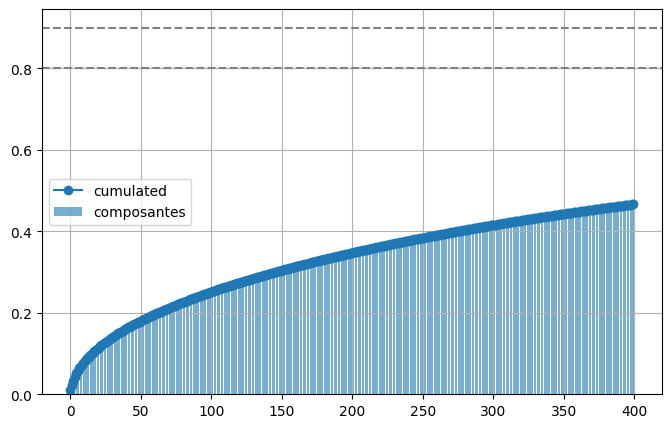

'\npipe_text = Pipeline([\n    ("tfidf",TfidfVectorizer(max_features=20000,min_df=5,stop_words="french")),\n    ("svd",TruncatedSVD(n_components=300\n'

In [47]:


cum_var = np.cumsum(svd.explained_variance_ratio_)
plt.figure(figsize=(8,5))
plt.bar(range(len(cum_var)),cum_var,alpha=0.6,label="composantes")
plt.plot(cum_var,marker="o",label="cumulated")
plt.axhline(0.8,color="gray",linestyle="--")
plt.axhline(0.9,color="gray",linestyle="--")
plt.legend()
plt.grid(True)
plt.show()




### Ici la courbe jusqu'à 400 composantes nous indique de l'informations, jusqu'à environ 45% le reste n'est surement que du bruit lexical ou peut-etre des variations
### dans le style d'écriture assez fin

### Commentaire – Early fusion

En early fusion, on concatène les features tabulaires et textuelles dans une seule représentation.  
Les performances obtenues sont très proches du modèle tabulaire seul : le texte apporte un léger complément, mais l’information principale reste dans les variables structurées.


In [54]:
# Let us start l'early fusion
_TARGET = "host_is_superhost"
_FULL_TEXT = "full_text"

# Colonnes
num_cols = (
    df.select_dtypes(include="number")
      .drop(columns=[_TARGET], errors="ignore")
      .columns.tolist()
)

cat_cols = (
    df.select_dtypes(exclude="number")
      .drop(columns=[_TARGET, _FULL_TEXT], errors="ignore")
      .columns.tolist()
)

# Pipelines par modalité
def text_modal():
    return Pipeline(steps=[
        ("tfidf", TfidfVectorizer(max_features=20000, min_df=5, stop_words="english")),
        ("svd", TruncatedSVD(n_components=400, random_state=42)),
    ])
def tabular_mod():
    pipe_numbers = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ])

    pipe_catego = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ])

    return pipe_numbers, pipe_catego


pipe_text = text_modal()
pipe_numbers,pipe_catego = tabular_mod()

# ColumnTransformer (early fusion)
CFR = ColumnTransformer(transformers=[
    ("text", pipe_text, _FULL_TEXT),
    ("num", pipe_numbers, num_cols),
    ("cat", pipe_catego, cat_cols),
])

# Pipeline complet
EARLY_FUSION = Pipeline(steps=[
    ("prep", CFR),
    ("clf", LogisticRegression(class_weight="balanced", max_iter=20000)),
])

# Séparation des données
X = df.drop(columns=[_TARGET])
y = df[_TARGET].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Entraînement
EARLY_FUSION.fit(X_train, y_train)

# Évaluation
proba = EARLY_FUSION.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)

print(classification_report(y_test, pred, digits=3))


              precision    recall  f1-score   support

           0      0.943     0.916     0.929     12514
           1      0.720     0.795     0.756      3394

    accuracy                          0.890     15908
   macro avg      0.831     0.856     0.842     15908
weighted avg      0.895     0.890     0.892     15908



In [59]:
%%writefile late_fusion.cpp


#include <pybind11/pybind11.h>
#include <pybind11/numpy.h>
#include <cassert>
#include <cmath>
#include <stdexcept>

/*for the namespace let us reduce it*/

namespace py = pybind11;

py::array_t<float> fusion(py::array_t<float>tab_a,py::array_t<float>tab_b,float w,float thresh){


     /*request the memory space where we stored our numpy array a and b */
    auto buf_a = tab_a.request();
    auto buf_b = tab_b.request();

    if(buf_a.size == 0 || buf_b.size == 0){
        throw std::runtime_error("Arrays are not to be empty !\n");
    }

    if(buf_a.size != buf_b.size){
        throw std::runtime_error("Buffers not of equal size\n");
    }

    /*let us verify the float variables w and thresh(threshold)*/

    if(!std::isfinite(w) || !std::isfinite(thresh)){
        throw std::runtime_error("w and thresh must be finite float!\n");
    }
    if(w < 0.0f || w > 1.0f){
        throw std::runtime_error("w's value must be in [0,1]\n");
    }
    if(thresh < 0.0f){
     throw std::runtime_error("Threshold cannot be below 0\n");
    }

   
    /*now in a same space to combine for our late fusion, text and tabular data must not necesserally belong to the same space
    however their set must be of equal size ex: R_text = 200 and R_tabular = 200 otherwise can't carry out any test*/
       if(buf_a.ndim != 1 || buf_b.ndim != 1){
        throw std::runtime_error("Your inputs must be of dim 1D\n");
      }

    //no null ptr thus format checking
    if(!buf_a.ptr || !buf_b.ptr) throw std::runtime_error("null pointers are not allowed\n");
    if ((buf_a.format != py::format_descriptor<float>::format()) ||
    (buf_b.format != py::format_descriptor<float>::format())) 
        {
            throw std::runtime_error("error not float32\n");
        }
    //threw a cast to my void pointers to have float32 buffers
    float* a = static_cast<float*>(buf_a.ptr);
    float* b = static_cast<float*>(buf_b.ptr);
    //allocation + memory access
    py::array_t<float>result(buf_a.size);
    auto buf_r = result.request();
    //casting to float to use my pointer to fill in the array
    float*r = static_cast<float*>(buf_r.ptr);
    
    //finally the calculation of our latefusion + w
    for(ssize_t i = 0; i< buf_a.size; ++i){
        float v = w * a[i] + (1.0f-w)*b[i];
        r[i] = (v > thresh) ? v : 0.0f;
    }
    return result;
    
}

PYBIND11_MODULE(late_fusion_cpp,m){
    m.def("fusion",&fusion);
}


Overwriting late_fusion.cpp


In [70]:
!where g++


Informationÿ: impossible de trouver des fichiers pour le(s) modŠle(s) sp‚cifi‚(s).


In [56]:
#Late fusion
#adding my personal cpp late_fusion

import late_fusion_cpp


pipe_text = text_modal()
pipe_numbers,pipe_catego = tabular_mod()

train_text = Pipeline(steps=[
    ("prep",pipe_text),
    ("clf",LogisticRegression(class_weight="balanced",max_iter=20000)),
])

tab_preprocess = ColumnTransformer([
    ("num", pipe_numbers, num_cols),
    ("cat", pipe_catego, cat_cols),
])

train_ca_num = Pipeline(steps=[
    ("prep",tab_preprocess),
    ("clf",LogisticRegression(class_weight="balanced",max_iter=20000)),])

X = df.drop(columns=[_TARGET])
y = df[_TARGET].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

train_text.fit(X_train[_FULL_TEXT],y_train)
train_ca_num.fit(X_train,y_train)

proba_text = train_text.predict_proba(X_test[_FULL_TEXT])[:,1]
proba_tab = train_ca_num.predict_proba(X_test)[:,1]

#Now the HEART OF THE LATE FUSION

proba = late_fusion_cpp.fusion(
    proba_text.astype("float32"),
    proba_tab.astype("float32"),
    0.5,
    0.5
)

pred = (proba >= 0.5).astype(int)
pred_text = (proba_text >= 0.5).astype(int)
pred_tab = (proba_tab >= 0.5).astype(int) 
print("Report late_fusion t\n")
print(classification_report(y_test,pred),end="\n"))
print("Report TEXT\n")
print(classification_report(y_test,pred_text,end="\n"))
print("Repoort TABULAR\n")
print(classification_report(y_test,pred_tab,end="\n"))




numpy.ndarray

### Commentaire – Late fusion

En late fusion, on combine les probabilités des deux modèles unimodaux :
- un modèle tabulaire très fort ;
- un modèle texte plus faible mais complémentaire.

La moyenne simple (alpha=0.5) donne déjà des performances comparables au tabulaire.  
Le balayage de `alpha` montre qu’un poids majoritaire sur le tabulaire (alpha > 0.5) est optimal, le texte jouant surtout un rôle de correction sur certains cas.


# 5. Conclusion générale

Sur ce jeu de données, les variables tabulaires suffisent à prédire presque parfaitement le statut Superhost, ce qui suggère une très forte redondance d'information avec la cible, voire une fuite d'information.  
Le texte (TF-IDF + modèles linéaires) apporte un signal complémentaire mais nettement moins puissant.

Les approches multimodales (early fusion, late fusion) n'apportent qu'un gain marginal par rapport au tabulaire seul, car la modalité tabulaire domine déjà l'information disponible.

Méthodologiquement, ce projet illustre :
- l'importance d'une exploration détaillée (déséquilibre, NA, corrélations, outliers) ;
- l'intérêt d'utiliser des métriques adaptées aux données déséquilibrées (F1, PR-AUC) ;
- la différence entre modèles unimodaux et multimodaux, et entre early et late fusion.

Pour aller plus loin :
- analyser/retirer les features trop proches de la cible pour éviter la fuite d'information ;
- utiliser une validation croisée plus rigoureuse ;
- tester des représentations texte plus riches (embeddings, modèles de langue) pour renforcer la contribution de la modalité texte.
